In [5]:
import pickle 
import pandas as pd
import wandb 

api = wandb.Api()



with open('../../data/Hazumi_features/Hazumi1911_features.pkl', mode='rb') as f:
    SS, TS, SP, TP, text, audio, visual,rtext, vid = pickle.load(f, encoding='utf-8')

def get_wandb_result(project_name):
    runs = api.runs(f"r-yanagimoto/{project_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    return runs_df

In [38]:
f1_0_text = {}
f1_0_audio = {}
f1_0_visual = {}
f1_0_multi = {}

f1_1_text = {}
f1_1_audio = {}
f1_1_visual = {}
f1_1_multi = {}

f1_2_text = {}
f1_2_audio = {}
f1_2_visual = {}
f1_2_multi = {}

runs_df = get_wandb_result("thirdsentiment-svm")
for _, run in runs_df.iterrows():
    uid = run["name"]
    modal = run["config"]["modal"]
    if modal == 't':
        f1_0_text[uid] = round(run['summary']['f1-0'], 2)
        f1_1_text[uid] = round(run['summary']['f1-1'], 2)
        f1_2_text[uid] = round(run['summary']['f1-2'], 2)
    elif modal == 'a':
        f1_0_audio[uid] = round(run['summary']['f1-0'], 2)
        f1_1_audio[uid] = round(run['summary']['f1-1'], 2)
        f1_2_audio[uid] = round(run['summary']['f1-2'], 2)
    elif modal == 'v':
        f1_0_visual[uid] = round(run['summary']['f1-0'], 2)
        f1_1_visual[uid] = round(run['summary']['f1-1'], 2)
        f1_2_visual[uid] = round(run['summary']['f1-2'], 2)
    else:
        f1_0_multi[uid] = round(run['summary']['f1-0'], 2)
        f1_1_multi[uid] = round(run['summary']['f1-1'], 2)
        f1_2_multi[uid] = round(run['summary']['f1-2'], 2)

acc = {
    "f1_0_text": f1_0_text,
    "f1_0_auido": f1_0_audio,
    "f1_0_visual": f1_0_visual,
    "f1_0_multi": f1_0_multi,
    "f1_1_text": f1_1_text,
    "f1_1_audio": f1_1_audio,
    "f1_1_visual": f1_1_visual,
    "f1_1_multi": f1_1_multi,
    "f1_2_text": f1_2_text,
    "f1_2_audio": f1_2_audio,
    "f1_2_visual": f1_2_visual,
    "f1_2_multi": f1_2_multi,
}

result_df = pd.DataFrame(acc)
# result_df.to_csv("hoge.txt", sep="&", header=False)
personality = {}
for uid in vid:
    personality[uid] = TP[uid]

personality_df = pd.DataFrame.from_dict(personality, orient="index", columns=["E", "A", "C", "N", "O"])

df = pd.concat([result_df, personality_df], axis=1)

In [34]:
import itertools # 効率的なループ実行のためのイテレータ生成関数のインポート import matplotlib.pyplot as plt # グラフ描画ライブラリ
import seaborn as sns # データの可視化を行うライブラリ
sns.set() # デフォルトスタイルにseabornを適用
from scipy.stats import pearsonr # 科学技術計算ライブラリ
import numpy as np # 数値計算を効率的に行うための拡張モジュール
import matplotlib.pyplot as plt 

traits = ['E', 'A', 'C', 'N', 'O']

def calc_p(df):
    for i, j in itertools.combinations(df, 2): #組み合わせでforループを実行
        if i in traits:
            continue
        if j not in traits:
            continue
        x = df.loc[:,[i]].values
        y = df.loc[:,[j]].values
        a, b = pearsonr(np.ravel(x), np.ravel(y)) # リストを整形し相関係数:aとp値:bの計算
        if 0 != b.round(10) < 0.05: # p値 < 0.05
            print("=" * 45)
            print(i + "----" + j)
            print("相関係数:", a.round(3))
            print("p値:", b.round(3))
            f1 = df.loc[:, i].values.tolist()
            p = df.loc[:, j].values.tolist()
            plt.scatter(f1, p)
            plt.title(i + "----" + j)
            plt.xlabel("F1-score")
            plt.ylabel(f"Big-5 score({j})")
            plt.xlim(0, 1)
            plt.ylim(2, 14)
            plt.show()

f1_0_text----N
相関係数: 0.518
p値: 0.007


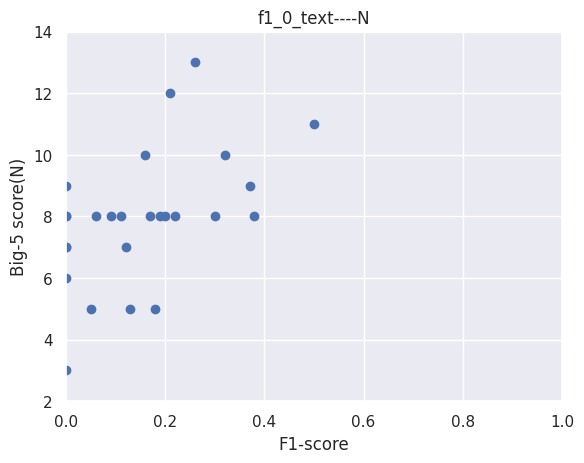

In [37]:
# 本人心象・本人性格特性
calc_p(df)

f1_0_text----C
相関係数: -0.4497
p値: 0.0212


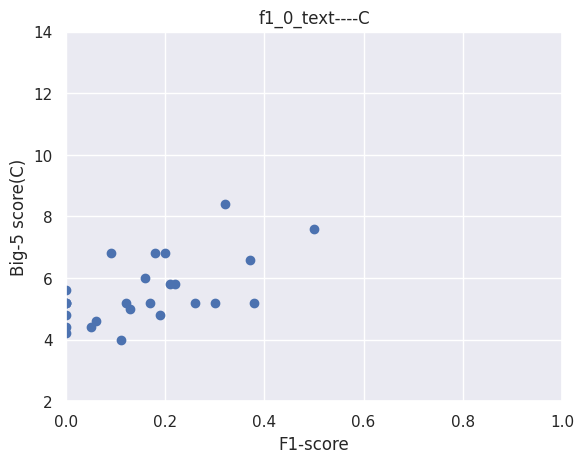

f1_0_text----N
相関係数: 0.5943
p値: 0.0014


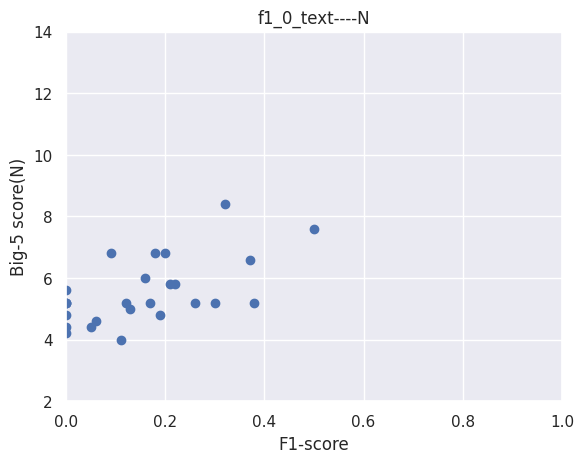

In [57]:
# 本人心象・第三者性格特性
calc_p(df)

f1_0_auido----N
相関係数: 0.5023
p値: 0.0089


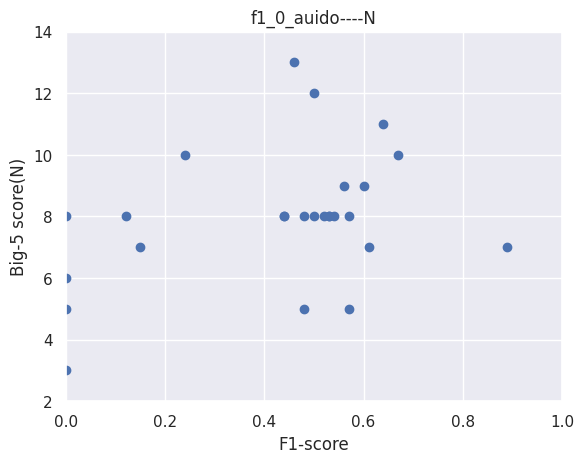

f1_0_visual----E
相関係数: -0.6466
p値: 0.0004


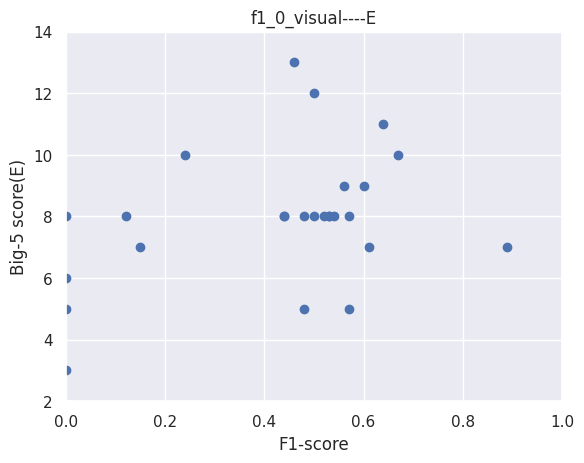

f1_2_text----C
相関係数: 0.5424
p値: 0.0042


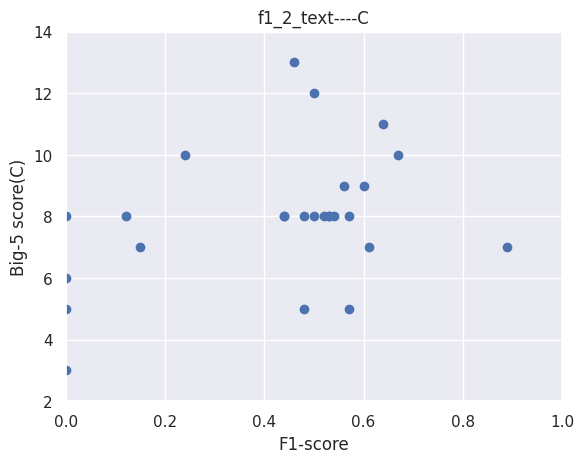

f1_2_multi----C
相関係数: 0.5019
p値: 0.009


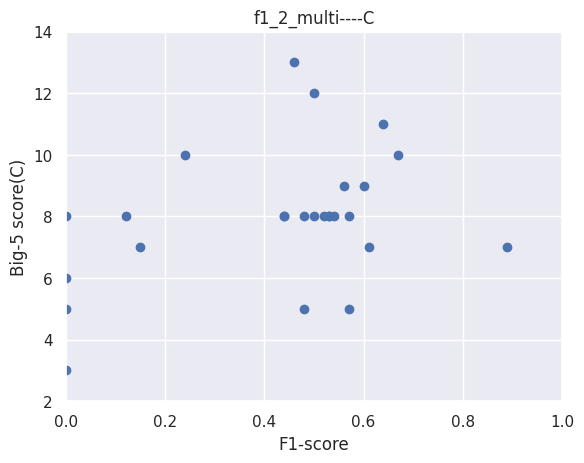

In [60]:
# 第三者心象・本人性格特性
calc_p(df)

f1_0_auido----C
相関係数: -0.395
p値: 0.046


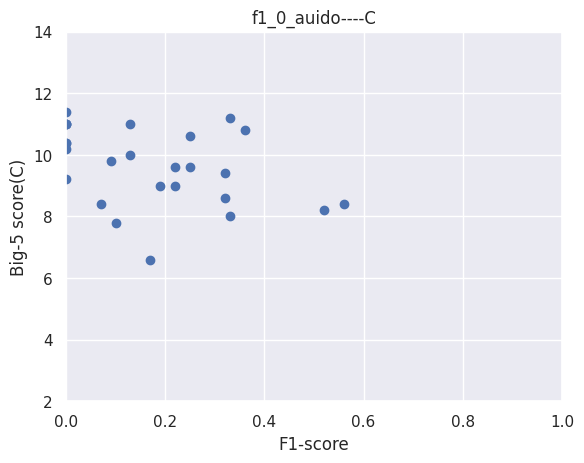

f1_0_auido----N
相関係数: 0.6
p値: 0.001


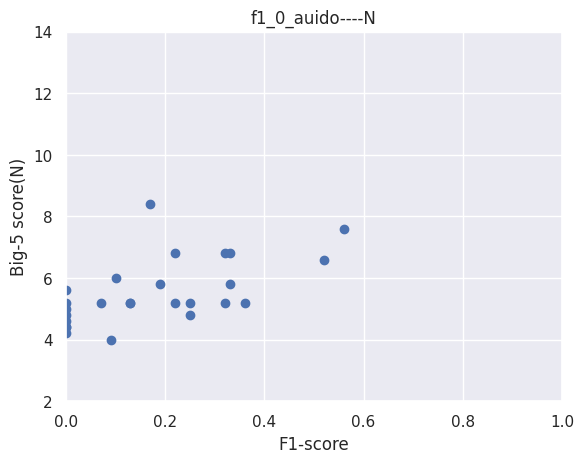

f1_0_auido----O
相関係数: -0.651
p値: 0.0


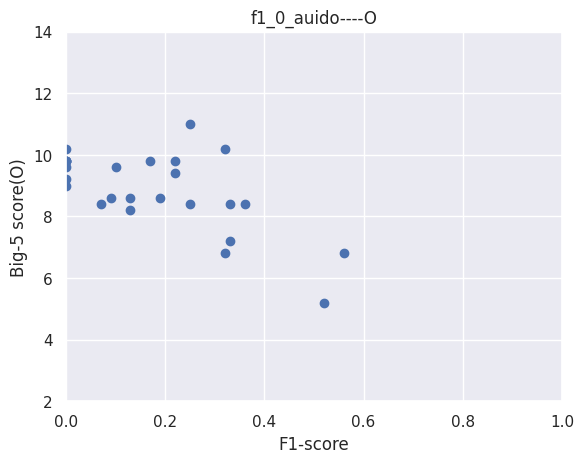

f1_0_visual----C
相関係数: -0.418
p値: 0.034


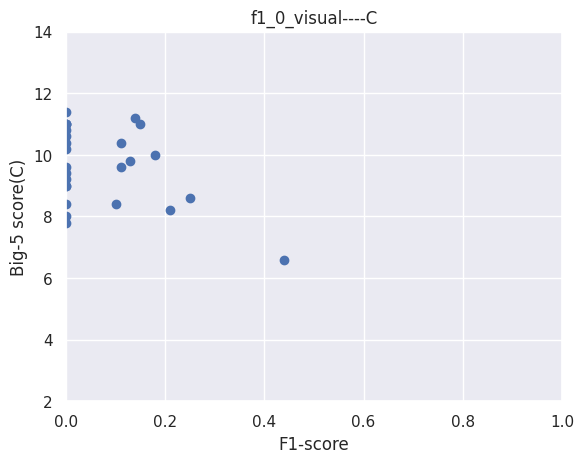

f1_0_visual----N
相関係数: 0.502
p値: 0.009


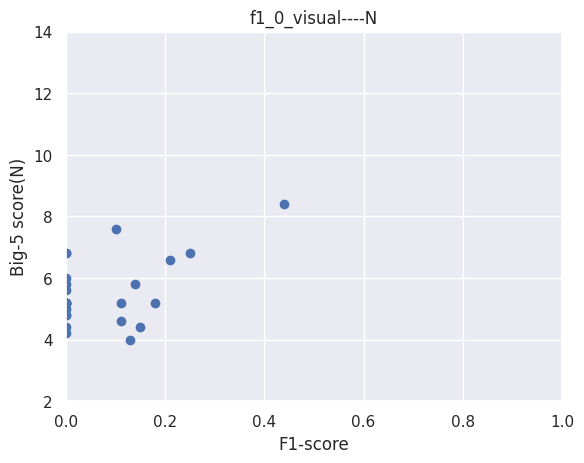

f1_2_text----C
相関係数: 0.436
p値: 0.026


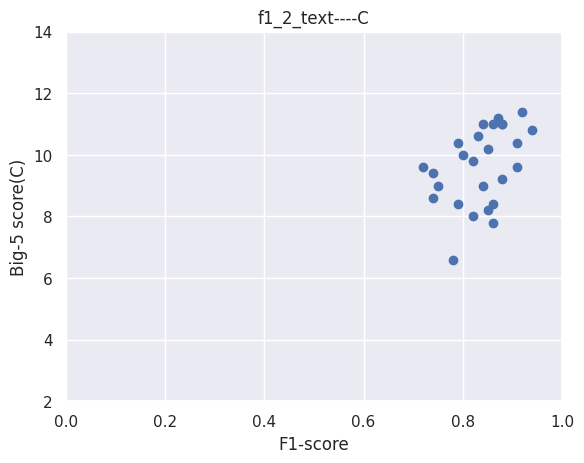

f1_2_multi----A
相関係数: 0.397
p値: 0.045


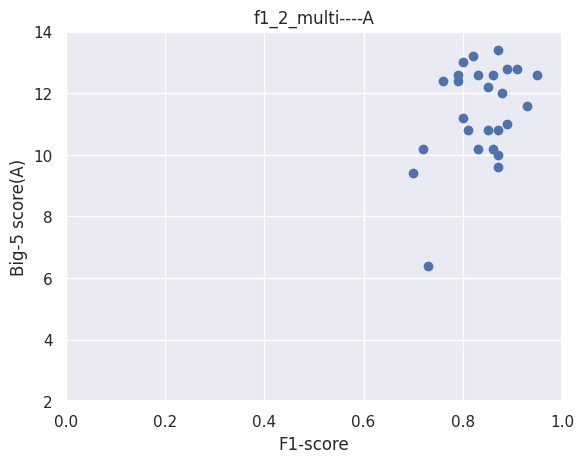

f1_2_multi----C
相関係数: 0.415
p値: 0.035


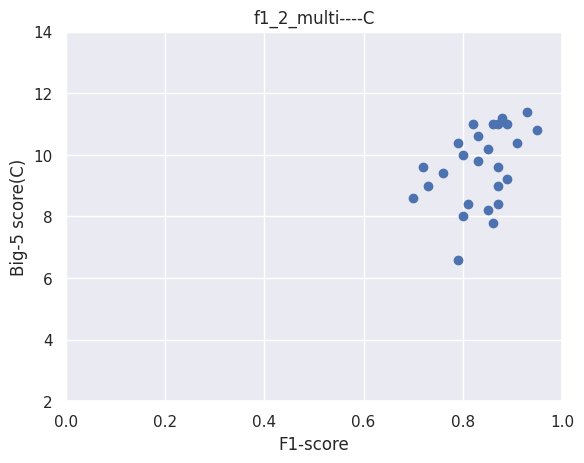

In [39]:
# 第三者心象・第三者性格特性
calc_p(df)